# MFU 수업: Layer별 FLOPs 추정 실습 가이드

## 🎯 실습 목표
- 딥러닝 모델의 각 레이어별 FLOPs(Floating Point Operations) 계산 방법 이해
- MFU(Model FLOPs Utilization) 측정 및 최적화 방법 학습
- 실제 모델에서의 computational efficiency 분석

---

## 📚 Part 1: 기초 개념 및 환경 설정

### 1.1 FLOPs와 MFU 개념 이해

## FLOPs (Floating Point Operations)란?

FLOPs는 모델이 수행하는 부동소수점 연산의 수를 의미합니다.
- **FLOPs**: 연산의 총 개수 (작은 s)
- **FLOPS**: 초당 연산 수 (대문자 S, Floating Point Operations Per Second)

## MFU (Model FLOPs Utilization)란?

MFU = (실제 달성한 FLOPS) / (이론적 최대 FLOPS) × 100%

GPU가 이론적으로 낼 수 있는 최대 성능 대비 실제 모델이 활용하는 비율을 나타냅니다.

### 1.2 필요 라이브러리 설치

In [1]:
# 필요한 패키지 설치
!pip install torch torchvision
!pip install thop
!pip install fvcore
!pip install ptflops
!pip install torchprofile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=0cd7c0eb9f1d6a311d320623cff26bc1be1b23e4fda32508d02fea9364ec3eaa
  Stored in directory: /root/.cache/pip/wheels/ed/9f/a5/e4f5b27454ccd4596bd8b62432c7d6b1ca9fa22aef9d70a16a
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=26c0f31353daf6500f683297a2dc83ac127d913da4000487b4aae893144e3b5e
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4f5f31ff812f684f69f40cb1634357812220aac58d4698048c
Successfully built fvcore iopath


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt

### 1.3 GPU 정보 확인

In [3]:
def get_gpu_info():
    """GPU 정보 및 이론적 최대 FLOPS 확인"""
    if torch.cuda.is_available():
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9

        # GPU별 이론적 TFLOPS (대략적인 값)
        theoretical_tflops = {
            'A100': 312,  # FP16 Tensor Core
            'V100': 125,  # FP16 Tensor Core
            'T4': 65,     # FP16 Tensor Core
            'P100': 21.2, # FP16
        }

        print(f"GPU: {gpu_name}")
        print(f"Memory: {gpu_memory:.2f} GB")

        for gpu_model, tflops in theoretical_tflops.items():
            if gpu_model in gpu_name:
                print(f"Theoretical Peak Performance: {tflops} TFLOPS (FP16)")
                return tflops * 1e12  # Convert to FLOPS

    return None

peak_flops = get_gpu_info()
peak_flops

GPU: NVIDIA A100-SXM4-40GB
Memory: 42.47 GB
Theoretical Peak Performance: 312 TFLOPS (FP16)


312000000000000.0

## 📊 Part 2: 기본 Layer별 FLOPs 계산

### 2.1 수동 FLOPs 계산 구현

In [4]:
class FLOPsCalculator:
    """각 레이어별 FLOPs를 수동으로 계산하는 클래스"""

    @staticmethod
    def conv2d_flops(in_channels, out_channels, kernel_size, input_size, stride=1, padding=0):
        """Conv2D 레이어의 FLOPs 계산

        FLOPs = 2 × K² × C_in × C_out × H_out × W_out
        """
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        if isinstance(stride, int):
            stride = (stride, stride)
        if isinstance(padding, int):
            padding = (padding, padding)

        h_out = (input_size[0] + 2 * padding[0] - kernel_size[0]) // stride[0] + 1
        w_out = (input_size[1] + 2 * padding[1] - kernel_size[1]) // stride[1] + 1

        # 곱셈과 덧셈 연산
        multiplications = kernel_size[0] * kernel_size[1] * in_channels * out_channels * h_out * w_out
        additions = (kernel_size[0] * kernel_size[1] * in_channels - 1) * out_channels * h_out * w_out

        # Bias 추가 (optional)
        bias_additions = out_channels * h_out * w_out

        total_flops = multiplications + additions + bias_additions

        return total_flops, (h_out, w_out)

    @staticmethod
    def linear_flops(in_features, out_features, batch_size=1):
        """Linear 레이어의 FLOPs 계산

        FLOPs = 2 × in_features × out_features × batch_size
        """
        multiplications = in_features * out_features * batch_size
        additions = (in_features - 1) * out_features * batch_size
        bias_additions = out_features * batch_size

        return multiplications + additions + bias_additions

    @staticmethod
    def attention_flops(seq_len, d_model, num_heads, batch_size=1):
        """Multi-Head Attention의 FLOPs 계산

        Q, K, V projection + Attention scores + Output projection
        """
        d_head = d_model // num_heads

        # Q, K, V projections
        qkv_flops = 3 * FLOPsCalculator.linear_flops(d_model, d_model, batch_size * seq_len)

        # Attention scores: Q @ K^T
        attention_scores = 2 * batch_size * num_heads * seq_len * seq_len * d_head

        # Softmax (approximated as seq_len operations per position)
        softmax_flops = batch_size * num_heads * seq_len * seq_len * 5  # rough approximation

        # Attention @ V
        attention_output = 2 * batch_size * num_heads * seq_len * seq_len * d_head

        # Output projection
        output_projection = FLOPsCalculator.linear_flops(d_model, d_model, batch_size * seq_len)

        total_flops = qkv_flops + attention_scores + softmax_flops + attention_output + output_projection

        return total_flops

### 2.2 실제 모델에 적용

In [5]:
# 간단한 CNN 모델 정의
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# FLOPs 계산
def calculate_model_flops(model, input_size=(32, 32)):
    """모델의 총 FLOPs 계산"""
    calculator = FLOPsCalculator()
    total_flops = 0
    layer_flops = {}

    # Conv1: 3 -> 64
    flops, output_size = calculator.conv2d_flops(3, 64, 3, input_size, padding=1)
    layer_flops['conv1'] = flops
    total_flops += flops
    output_size = (output_size[0]//2, output_size[1]//2)  # After pooling

    # Conv2: 64 -> 128
    flops, output_size = calculator.conv2d_flops(64, 128, 3, output_size, padding=1)
    layer_flops['conv2'] = flops
    total_flops += flops
    output_size = (output_size[0]//2, output_size[1]//2)  # After pooling

    # Conv3: 128 -> 256
    flops, output_size = calculator.conv2d_flops(128, 256, 3, output_size, padding=1)
    layer_flops['conv3'] = flops
    total_flops += flops
    output_size = (output_size[0]//2, output_size[1]//2)  # After pooling

    # FC1: 256*4*4 -> 512
    flops = calculator.linear_flops(256 * 4 * 4, 512)
    layer_flops['fc1'] = flops
    total_flops += flops

    # FC2: 512 -> 10
    flops = calculator.linear_flops(512, 10)
    layer_flops['fc2'] = flops
    total_flops += flops

    return total_flops, layer_flops

model = SimpleCNN()
total_flops, layer_flops = calculate_model_flops(model)

print(f"Total FLOPs: {total_flops:,}")
print("\nLayer-wise FLOPs:")
for layer, flops in layer_flops.items():
    print(f"  {layer}: {flops:,} ({flops/total_flops*100:.2f}%)")

Total FLOPs: 83,240,960

Layer-wise FLOPs:
  conv1: 3,538,944 (4.25%)
  conv2: 37,748,736 (45.35%)
  conv3: 37,748,736 (45.35%)
  fc1: 4,194,304 (5.04%)
  fc2: 10,240 (0.01%)


## 🔧 Part 3: 자동 FLOPs 프로파일링 도구 활용

### 3.1 THOP 라이브러리 사용

In [6]:
from thop import profile, clever_format

def profile_with_thop(model, input_size=(1, 3, 32, 32)):
    """THOP을 사용한 FLOPs 프로파일링"""
    input_tensor = torch.randn(input_size)

    # FLOPs와 Parameters 계산
    flops, params = profile(model, inputs=(input_tensor,))

    # 읽기 쉬운 형태로 변환
    flops, params = clever_format([flops, params], "%.3f")

    print(f"Model FLOPs: {flops}")
    print(f"Model Parameters: {params}")

    return flops, params

# 모델 프로파일링
model = SimpleCNN()
flops, params = profile_with_thop(model)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
Model FLOPs: 41.620M
Model Parameters: 2.474M


### 3.2 FVCore 라이브러리 사용

In [7]:
from fvcore.nn import FlopCountAnalysis, parameter_count

def profile_with_fvcore(model, input_size=(1, 3, 32, 32)):
    """FVCore를 사용한 상세 FLOPs 분석"""
    input_tensor = torch.randn(input_size)

    # FLOPs 분석
    flops = FlopCountAnalysis(model, input_tensor)

    # 총 FLOPs
    total_flops = flops.total()

    # 레이어별 FLOPs
    layer_flops = flops.by_module()

    # 연산 타입별 FLOPs
    op_flops = flops.by_operator()

    print(f"Total FLOPs: {total_flops:,}")
    print("\nFLOPs by Layer:")
    for name, flops_count in layer_flops.items():
        if flops_count > 0:
            print(f"  {name}: {flops_count:,}")

    print("\nFLOPs by Operation Type:")
    for op, flops_count in op_flops.items():
        if flops_count > 0:
            print(f"  {op}: {flops_count:,}")

    return total_flops, layer_flops, op_flops

# FVCore로 분석
total_flops, layer_flops, op_flops = profile_with_fvcore(model)

Total FLOPs: 41,620,480

FLOPs by Layer:
  : 41,620,480
  conv1: 1,769,472
  conv2: 18,874,368
  conv3: 18,874,368
  fc1: 2,097,152
  fc2: 5,120

FLOPs by Operation Type:
  conv: 39,518,208
  linear: 2,102,272


### 3.3 Custom Hook을 사용한 레이어별 분석

In [8]:
class LayerProfiler:
    """Hook을 사용한 레이어별 상세 프로파일링"""

    def __init__(self):
        self.layer_stats = {}

    def hook_fn(self, module, input, output, name):
        """각 레이어의 입출력 shape 및 FLOPs 기록"""
        input_shape = input[0].shape if isinstance(input, tuple) else input.shape
        output_shape = output.shape if hasattr(output, 'shape') else output[0].shape

        self.layer_stats[name] = {
            'input_shape': input_shape,
            'output_shape': output_shape,
            'module_type': module.__class__.__name__
        }

        # 간단한 FLOPs 추정
        if isinstance(module, nn.Conv2d):
            flops = self._conv_flops(module, output_shape)
            self.layer_stats[name]['flops'] = flops
        elif isinstance(module, nn.Linear):
            flops = self._linear_flops(module, output_shape)
            self.layer_stats[name]['flops'] = flops

    def _conv_flops(self, module, output_shape):
        batch_size = output_shape[0]
        out_h, out_w = output_shape[2], output_shape[3]
        kernel_h, kernel_w = module.kernel_size
        in_channels = module.in_channels
        out_channels = module.out_channels

        return 2 * batch_size * out_h * out_w * in_channels * out_channels * kernel_h * kernel_w

    def _linear_flops(self, module, output_shape):
        batch_size = output_shape[0]
        return 2 * batch_size * module.in_features * module.out_features

    def profile_model(self, model, input_tensor):
        """모델 전체 프로파일링"""
        handles = []

        # 각 레이어에 hook 등록
        for name, module in model.named_modules():
            if len(list(module.children())) == 0:  # Leaf modules only
                handle = module.register_forward_hook(
                    lambda m, i, o, n=name: self.hook_fn(m, i, o, n)
                )
                handles.append(handle)

        # Forward pass
        with torch.no_grad():
            _ = model(input_tensor)

        # Hook 제거
        for handle in handles:
            handle.remove()

        return self.layer_stats

# 프로파일링 실행
profiler = LayerProfiler()
input_tensor = torch.randn(1, 3, 32, 32)
layer_stats = profiler.profile_model(model, input_tensor)

print("Layer-wise Statistics:")
for name, stats in layer_stats.items():
    print(f"\n{name} ({stats['module_type']}):")
    print(f"  Input shape: {stats['input_shape']}")
    print(f"  Output shape: {stats['output_shape']}")
    if 'flops' in stats:
        print(f"  FLOPs: {stats['flops']:,}")

Layer-wise Statistics:

conv1 (Conv2d):
  Input shape: torch.Size([1, 3, 32, 32])
  Output shape: torch.Size([1, 64, 32, 32])
  FLOPs: 3,538,944

pool (MaxPool2d):
  Input shape: torch.Size([1, 256, 8, 8])
  Output shape: torch.Size([1, 256, 4, 4])

conv2 (Conv2d):
  Input shape: torch.Size([1, 64, 16, 16])
  Output shape: torch.Size([1, 128, 16, 16])
  FLOPs: 37,748,736

conv3 (Conv2d):
  Input shape: torch.Size([1, 128, 8, 8])
  Output shape: torch.Size([1, 256, 8, 8])
  FLOPs: 37,748,736

fc1 (Linear):
  Input shape: torch.Size([1, 4096])
  Output shape: torch.Size([1, 512])
  FLOPs: 4,194,304

fc2 (Linear):
  Input shape: torch.Size([1, 512])
  Output shape: torch.Size([1, 10])
  FLOPs: 10,240


## 🚀 Part 4: MFU 측정 및 최적화

### 4.1 실제 처리량 측정

In [9]:
def measure_throughput(model, batch_size, input_size=(3, 32, 32), num_iterations=100):
    """모델의 실제 처리량(throughput) 측정"""
    model = model.cuda()
    model.eval()

    # Warm-up
    dummy_input = torch.randn(batch_size, *input_size).cuda()
    for _ in range(10):
        _ = model(dummy_input)

    torch.cuda.synchronize()

    # 실제 측정
    start_time = time.time()

    for _ in range(num_iterations):
        with torch.no_grad():
            _ = model(dummy_input)

    torch.cuda.synchronize()
    end_time = time.time()

    # 처리량 계산
    elapsed_time = end_time - start_time
    throughput = (batch_size * num_iterations) / elapsed_time

    return throughput, elapsed_time

# 다양한 배치 크기로 테스트
batch_sizes = [1, 8, 16, 32, 64, 128]
throughputs = []

for bs in batch_sizes:
    try:
        throughput, elapsed_time = measure_throughput(model, bs)
        throughputs.append(throughput)
        print(f"Batch size {bs}: {throughput:.2f} samples/sec")
    except RuntimeError as e:
        print(f"Batch size {bs}: OOM")
        throughputs.append(0)

Batch size 1: 2487.39 samples/sec
Batch size 8: 19678.63 samples/sec
Batch size 16: 39669.25 samples/sec
Batch size 32: 72117.03 samples/sec
Batch size 64: 137921.61 samples/sec
Batch size 128: 227214.25 samples/sec


### 4.2 MFU 계산

In [11]:
def calculate_mfu_fixed(model, batch_size, input_size=(3, 32, 32), peak_flops=None):
    """
    Model FLOPs Utilization 계산 (Device 오류 수정 버전)

    Args:
        model: PyTorch 모델
        batch_size: 배치 크기
        input_size: 입력 크기 (C, H, W)
        peak_flops: GPU의 이론적 최대 FLOPS

    Returns:
        dict: MFU 계산 결과
    """

    # 1. Device 확인 및 설정
    device = next(model.parameters()).device
    print(f"📍 모델 device: {device}")

    # 2. 입력 텐서를 모델과 같은 device에 생성
    input_tensor = torch.randn(batch_size, *input_size).to(device)
    print(f"📍 입력 텐서 device: {input_tensor.device}")

    # 3. FLOPs 계산
    try:
        from fvcore.nn import FlopCountAnalysis
        flops = FlopCountAnalysis(model, input_tensor).total()
    except Exception as e:
        print(f"⚠️ FVCore 에러: {e}")
        # 대체 방법 사용
        from thop import profile
        flops, _ = profile(model, inputs=(input_tensor,), verbose=False)

    # 4. 실제 처리량 측정 (수정된 버전)
    throughput, elapsed_time = measure_throughput_fixed(model, batch_size, input_size)

    # 5. 실제 FLOPS 계산
    actual_flops_per_sec = flops * throughput / batch_size

    # 6. MFU 계산
    if peak_flops:
        mfu = (actual_flops_per_sec / peak_flops) * 100
    else:
        mfu = None

    results = {
        'batch_size': batch_size,
        'model_flops': flops,
        'throughput': throughput,
        'actual_flops_per_sec': actual_flops_per_sec,
        'mfu_percentage': mfu,
        'device': str(device)
    }

    return results

def measure_throughput_fixed(model, batch_size, input_size=(3, 32, 32), num_iterations=100):
    """
    모델의 실제 처리량(throughput) 측정 (Device 오류 수정 버전)
    """
    # 모델의 device 확인
    device = next(model.parameters()).device

    # 모델을 eval 모드로 설정
    model.eval()

    # Warm-up (중요!)
    print("🔥 Warming up...")
    dummy_input = torch.randn(batch_size, *input_size).to(device)  # device 지정

    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)

    # GPU 동기화
    if device.type == 'cuda':
        torch.cuda.synchronize()

    # 실제 측정
    print("📊 Measuring throughput...")
    start_time = time.time()

    with torch.no_grad():
        for _ in range(num_iterations):
            _ = model(dummy_input)

    # GPU 동기화
    if device.type == 'cuda':
        torch.cuda.synchronize()

    end_time = time.time()

    # 처리량 계산
    elapsed_time = end_time - start_time
    throughput = (batch_size * num_iterations) / elapsed_time

    print(f"✅ 측정 완료: {throughput:.2f} samples/sec")

    return throughput, elapsed_time

# ====================================
# 🎯 실행 예제
# ====================================

# 모델 생성 및 GPU 이동
model = SimpleCNN()

# GPU 사용 가능 여부 확인
if torch.cuda.is_available():
    model = model.cuda()
    print("✅ GPU 사용 중")
else:
    print("⚠️ CPU 사용 중 (GPU 권장)")

# MFU 측정 (수정된 함수 사용)
results = calculate_mfu_fixed(model, batch_size=32, peak_flops=peak_flops)

# 결과 출력
print("\n" + "="*50)
print("📊 MFU 측정 결과")
print("="*50)
print(f"Device: {results['device']}")
print(f"Model FLOPs: {results['model_flops']:,}")
print(f"Throughput: {results['throughput']:.2f} samples/sec")
print(f"Actual FLOPS: {results['actual_flops_per_sec']:.2e}")
if results['mfu_percentage']:
    print(f"MFU: {results['mfu_percentage']:.2f}%")
else:
    print("MFU: N/A (peak_flops not provided)")

✅ GPU 사용 중
📍 모델 device: cuda:0
📍 입력 텐서 device: cuda:0
🔥 Warming up...
📊 Measuring throughput...
✅ 측정 완료: 73042.47 samples/sec

📊 MFU 측정 결과
Device: cuda:0
Model FLOPs: 1,331,855,360
Throughput: 73042.47 samples/sec
Actual FLOPS: 3.04e+12
MFU: 0.97%


### 4.3 배치 크기별 MFU 분석

📍 모델 device: cuda:0
📍 입력 텐서 device: cuda:0
🔥 Warming up...
📊 Measuring throughput...
✅ 측정 완료: 1409.52 samples/sec
Batch 1: MFU = 0.02%
📍 모델 device: cuda:0
📍 입력 텐서 device: cuda:0
🔥 Warming up...
📊 Measuring throughput...


✅ 측정 완료: 5260.44 samples/sec
Batch 4: MFU = 0.07%
📍 모델 device: cuda:0
📍 입력 텐서 device: cuda:0
🔥 Warming up...
📊 Measuring throughput...
✅ 측정 완료: 9991.29 samples/sec
Batch 8: MFU = 0.13%
📍 모델 device: cuda:0
📍 입력 텐서 device: cuda:0
🔥 Warming up...
📊 Measuring throughput...


✅ 측정 완료: 21846.68 samples/sec
Batch 16: MFU = 0.29%
📍 모델 device: cuda:0
📍 입력 텐서 device: cuda:0
🔥 Warming up...
📊 Measuring throughput...
✅ 측정 완료: 42950.91 samples/sec
Batch 32: MFU = 0.57%
📍 모델 device: cuda:0
📍 입력 텐서 device: cuda:0
🔥 Warming up...
📊 Measuring throughput...
✅ 측정 완료: 83851.23 samples/sec
Batch 64: MFU = 1.12%


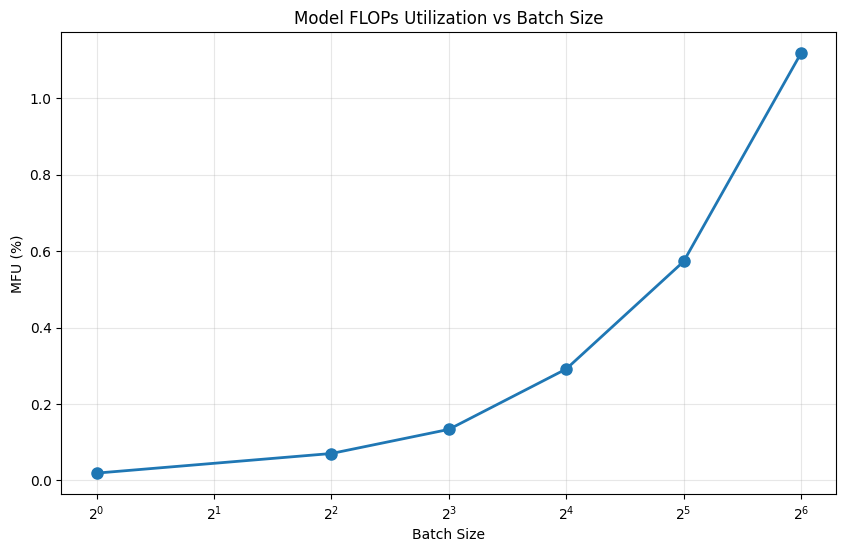

In [15]:
def analyze_mfu_vs_batch_size(model, batch_sizes, peak_flops=None):
    """배치 크기에 따른 MFU 변화 분석"""
    results = []

    for bs in batch_sizes:
        try:
            result = calculate_mfu_fixed(model, bs, peak_flops=peak_flops)
            results.append(result)
            print(f"Batch {bs}: MFU = {result['mfu_percentage']:.2f}%" if result['mfu_percentage'] else f"Batch {bs}: Completed")
        except RuntimeError:
            print(f"Batch {bs}: OOM")

    return results

# 분석 실행
batch_sizes = [1, 4, 8, 16, 32, 64]
mfu_results = analyze_mfu_vs_batch_size(model, batch_sizes, peak_flops)

# 시각화
if mfu_results and any(r['mfu_percentage'] for r in mfu_results):
    plt.figure(figsize=(10, 6))
    valid_results = [r for r in mfu_results if r['mfu_percentage']]

    batch_sizes_plot = [r['batch_size'] for r in valid_results]
    mfu_values = [r['mfu_percentage'] for r in valid_results]

    plt.plot(batch_sizes_plot, mfu_values, 'o-', linewidth=2, markersize=8)
    plt.xlabel('Batch Size')
    plt.ylabel('MFU (%)')
    plt.title('Model FLOPs Utilization vs Batch Size')
    plt.grid(True, alpha=0.3)
    plt.xscale('log', base=2)
    plt.show()

## 🔍 Part 5: Transformer 모델 FLOPs 분석

### 5.1 Transformer 블록 구현 및 분석

In [16]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model=512, num_heads=8, d_ff=2048, dropout=0.1):
        super().__init__()
        self.attention = nn.MultiheadAttention(d_model, num_heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model)
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Self-attention
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + self.dropout(attn_output))

        # Feed-forward
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))

        return x

def analyze_transformer_flops(seq_len=128, d_model=512, num_heads=8, d_ff=2048, batch_size=1):
    """Transformer 블록의 FLOPs 분석"""
    calculator = FLOPsCalculator()

    # Attention FLOPs
    attention_flops = calculator.attention_flops(seq_len, d_model, num_heads, batch_size)

    # Feed-forward FLOPs
    ff_flops = calculator.linear_flops(d_model, d_ff, batch_size * seq_len)
    ff_flops += calculator.linear_flops(d_ff, d_model, batch_size * seq_len)

    # LayerNorm FLOPs (approximation)
    ln_flops = 2 * 5 * d_model * seq_len * batch_size  # rough approximation

    total_flops = attention_flops + ff_flops + ln_flops

    print(f"Transformer Block FLOPs Analysis:")
    print(f"  Attention: {attention_flops:,} ({attention_flops/total_flops*100:.1f}%)")
    print(f"  Feed-forward: {ff_flops:,} ({ff_flops/total_flops*100:.1f}%)")
    print(f"  LayerNorm: {ln_flops:,} ({ln_flops/total_flops*100:.1f}%)")
    print(f"  Total: {total_flops:,}")

    return total_flops

# 다양한 시퀀스 길이에서 분석
seq_lengths = [64, 128, 256, 512, 1024]
flops_by_seq_len = []

for seq_len in seq_lengths:
    flops = analyze_transformer_flops(seq_len=seq_len)
    flops_by_seq_len.append(flops)
    print(f"\nSeq Length {seq_len}: {flops:,} FLOPs")

Transformer Block FLOPs Analysis:
  Attention: 142,770,176 (34.7%)
  Feed-forward: 268,435,456 (65.2%)
  LayerNorm: 327,680 (0.1%)
  Total: 411,533,312

Seq Length 64: 411,533,312 FLOPs
Transformer Block FLOPs Analysis:
  Attention: 302,645,248 (36.0%)
  Feed-forward: 536,870,912 (63.9%)
  LayerNorm: 655,360 (0.1%)
  Total: 840,171,520

Seq Length 128: 840,171,520 FLOPs
Transformer Block FLOPs Analysis:
  Attention: 673,710,080 (38.5%)
  Feed-forward: 1,073,741,824 (61.4%)
  LayerNorm: 1,310,720 (0.1%)
  Total: 1,748,762,624

Seq Length 256: 1,748,762,624 FLOPs
Transformer Block FLOPs Analysis:
  Attention: 1,621,098,496 (43.0%)
  Feed-forward: 2,147,483,648 (56.9%)
  LayerNorm: 2,621,440 (0.1%)
  Total: 3,771,203,584

Seq Length 512: 3,771,203,584 FLOPs
Transformer Block FLOPs Analysis:
  Attention: 4,336,910,336 (50.2%)
  Feed-forward: 4,294,967,296 (49.7%)
  LayerNorm: 5,242,880 (0.1%)
  Total: 8,637,120,512

Seq Length 1024: 8,637,120,512 FLOPs


### 5.2 실제 Transformer 모델 프로파일링

In [17]:
import torch.nn.functional as F

class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size=10000, d_model=512, num_heads=8,
                 num_layers=6, d_ff=2048, max_seq_len=512):
        super().__init__()
        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = nn.Parameter(torch.randn(1, max_seq_len, d_model))

        self.layers = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff)
            for _ in range(num_layers)
        ])

        self.ln_final = nn.LayerNorm(d_model)
        self.output_projection = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        seq_len = x.size(1)

        # Token + Positional embeddings
        x = self.embedding(x) * (self.d_model ** 0.5)
        x = x + self.positional_encoding[:, :seq_len, :]

        # Transformer layers
        for layer in self.layers:
            x = layer(x)

        # Output
        x = self.ln_final(x)
        x = self.output_projection(x)

        return x

# 모델 생성 및 프로파일링
transformer_model = SimpleTransformer(num_layers=6)
input_ids = torch.randint(0, 10000, (1, 128))  # [batch_size, seq_len]

# THOP으로 프로파일링
flops, params = profile(transformer_model, inputs=(input_ids,))
flops, params = clever_format([flops, params], "%.3f")
print(f"Transformer Model FLOPs: {flops}")
print(f"Transformer Model Parameters: {params}")

[INFO] Register count_normalization() for <class 'torch.nn.modules.normalization.LayerNorm'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
Transformer Model FLOPs: 2.269G
Transformer Model Parameters: 17.742M


## 📈 Part 6: 최적화 기법 실습

### 6.1 Mixed Precision Training의 FLOPs 영향

In [18]:
from torch.cuda.amp import autocast, GradScaler

def compare_precision_performance(model, input_tensor, num_iterations=100):
    """FP32 vs FP16 성능 비교"""
    model = model.cuda()
    input_tensor = input_tensor.cuda()

    # FP32 측정
    torch.cuda.synchronize()
    start_fp32 = time.time()

    for _ in range(num_iterations):
        with torch.no_grad():
            _ = model(input_tensor)

    torch.cuda.synchronize()
    time_fp32 = time.time() - start_fp32

    # FP16 측정
    torch.cuda.synchronize()
    start_fp16 = time.time()

    for _ in range(num_iterations):
        with torch.no_grad():
            with autocast():
                _ = model(input_tensor)

    torch.cuda.synchronize()
    time_fp16 = time.time() - start_fp16

    speedup = time_fp32 / time_fp16

    print(f"FP32 time: {time_fp32:.3f} sec")
    print(f"FP16 time: {time_fp16:.3f} sec")
    print(f"Speedup: {speedup:.2f}x")

    return time_fp32, time_fp16, speedup

# 테스트
model = SimpleCNN()
input_tensor = torch.randn(32, 3, 32, 32)
compare_precision_performance(model, input_tensor)

/tmp/ipython-input-3889274288.py:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


FP32 time: 0.044 sec
FP16 time: 0.387 sec
Speedup: 0.12x


(0.04446244239807129, 0.38651466369628906, 0.11503429642971699)

### 6.2 모델 최적화 기법

In [20]:
import copy
def optimize_model_for_inference(model):
    """추론 최적화 기법 적용"""
    model.eval()

    # 1. Torch Script로 변환
    example_input = torch.randn(1, 3, 32, 32)
    scripted_model = torch.jit.trace(model, example_input)

    # 2. CUDA로 이동 및 최적화
    if torch.cuda.is_available():
        model = model.cuda()
        scripted_model = scripted_model.cuda()

        # CUDNN 벤치마크 활성화
        torch.backends.cudnn.benchmark = True

    return scripted_model

# 최적화 전후 비교
original_model = SimpleCNN()
optimized_model = optimize_model_for_inference(copy.deepcopy(original_model))

# 성능 측정
input_tensor = torch.randn(32, 3, 32, 32).cuda()

# Original
start = time.time()
for _ in range(100):
    with torch.no_grad():
        _ = original_model.cuda()(input_tensor)
torch.cuda.synchronize()
original_time = time.time() - start

# Optimized
start = time.time()
for _ in range(100):
    with torch.no_grad():
        _ = optimized_model(input_tensor)
torch.cuda.synchronize()
optimized_time = time.time() - start

print(f"Original model: {original_time:.3f} sec")
print(f"Optimized model: {optimized_time:.3f} sec")
print(f"Speedup: {original_time/optimized_time:.2f}x")

Original model: 0.060 sec
Optimized model: 0.047 sec
Speedup: 1.28x


### 6.3 Operator Fusion의 영향 분석

In [21]:
class UnfusedBlock(nn.Module):
    """Fusion이 안된 블록"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class FusedBlock(nn.Module):
    """Fusion된 블록"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_bn_relu = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_bn_relu(x)

# 성능 비교
unfused = UnfusedBlock(64, 128).cuda()
fused = FusedBlock(64, 128).cuda()
input_tensor = torch.randn(32, 64, 32, 32).cuda()

# 측정
for name, module in [("Unfused", unfused), ("Fused", fused)]:
    torch.cuda.synchronize()
    start = time.time()

    for _ in range(1000):
        with torch.no_grad():
            _ = module(input_tensor)

    torch.cuda.synchronize()
    elapsed = time.time() - start
    print(f"{name}: {elapsed:.3f} sec")

Unfused: 0.285 sec
Fused: 0.175 sec


## 💡 Part 7: 실전 프로젝트 (1시간)

### 7.1 종합 프로파일링 도구 구축

In [22]:
class ComprehensiveProfiler:
    """종합적인 모델 프로파일링 도구"""

    def __init__(self, model, input_shape, device='cuda'):
        self.model = model.to(device)
        self.input_shape = input_shape
        self.device = device
        self.results = {}

    def profile_all(self, batch_sizes=[1, 8, 16, 32]):
        """전체 프로파일링 수행"""

        # 1. 모델 정보
        self._profile_model_info()

        # 2. FLOPs 계산
        self._profile_flops()

        # 3. 메모리 사용량
        self._profile_memory()

        # 4. 배치별 성능
        self._profile_batch_performance(batch_sizes)

        # 5. MFU 계산
        self._calculate_mfu()

        return self.results

    def _profile_model_info(self):
        """모델 기본 정보"""
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)

        self.results['model_info'] = {
            'total_parameters': total_params,
            'trainable_parameters': trainable_params,
            'model_size_mb': total_params * 4 / 1024 / 1024  # Assuming FP32
        }

    def _profile_flops(self):
        """FLOPs 프로파일링"""
        input_tensor = torch.randn(1, *self.input_shape).to(self.device)
        flops = FlopCountAnalysis(self.model, input_tensor).total()

        self.results['flops'] = {
            'total_flops': flops,
            'gflops': flops / 1e9
        }

    def _profile_memory(self):
        """메모리 사용량 프로파일링"""
        if self.device == 'cuda':
            torch.cuda.reset_peak_memory_stats()

            input_tensor = torch.randn(1, *self.input_shape).to(self.device)
            _ = self.model(input_tensor)

            self.results['memory'] = {
                'peak_memory_mb': torch.cuda.max_memory_allocated() / 1024 / 1024,
                'current_memory_mb': torch.cuda.memory_allocated() / 1024 / 1024
            }

    def _profile_batch_performance(self, batch_sizes):
        """배치 크기별 성능 측정"""
        performances = []

        for bs in batch_sizes:
            try:
                input_tensor = torch.randn(bs, *self.input_shape).to(self.device)

                # Warm-up
                for _ in range(5):
                    _ = self.model(input_tensor)

                # Measure
                if self.device == 'cuda':
                    torch.cuda.synchronize()

                start = time.time()
                iterations = 50

                for _ in range(iterations):
                    with torch.no_grad():
                        _ = self.model(input_tensor)

                if self.device == 'cuda':
                    torch.cuda.synchronize()

                elapsed = time.time() - start
                throughput = (bs * iterations) / elapsed

                performances.append({
                    'batch_size': bs,
                    'throughput': throughput,
                    'latency_ms': (elapsed / iterations) * 1000
                })

            except RuntimeError as e:
                performances.append({
                    'batch_size': bs,
                    'error': str(e)
                })

        self.results['batch_performance'] = performances

    def _calculate_mfu(self):
        """MFU 계산"""
        if 'flops' in self.results and 'batch_performance' in self.results:
            # GPU 이론적 성능 (TFLOPS)
            gpu_tflops = {
                'V100': 125,
                'A100': 312,
                'T4': 65
            }

            if self.device == 'cuda':
                gpu_name = torch.cuda.get_device_name(0)
                peak_tflops = 100  # Default

                for gpu, tflops in gpu_tflops.items():
                    if gpu in gpu_name:
                        peak_tflops = tflops
                        break

                mfu_results = []
                for perf in self.results['batch_performance']:
                    if 'throughput' in perf:
                        actual_tflops = (self.results['flops']['total_flops'] * perf['throughput']) / 1e12
                        mfu = (actual_tflops / peak_tflops) * 100

                        mfu_results.append({
                            'batch_size': perf['batch_size'],
                            'actual_tflops': actual_tflops,
                            'mfu_percentage': mfu
                        })

                self.results['mfu'] = {
                    'peak_tflops': peak_tflops,
                    'measurements': mfu_results
                }

    def generate_report(self):
        """프로파일링 결과 리포트 생성"""
        print("="*60)
        print("MODEL PROFILING REPORT")
        print("="*60)

        # Model Info
        if 'model_info' in self.results:
            print("\n📊 Model Information:")
            info = self.results['model_info']
            print(f"  Total Parameters: {info['total_parameters']:,}")
            print(f"  Model Size: {info['model_size_mb']:.2f} MB")

        # FLOPs
        if 'flops' in self.results:
            print("\n💻 Computational Complexity:")
            print(f"  Total FLOPs: {self.results['flops']['gflops']:.2f} GFLOPs")

        # Memory
        if 'memory' in self.results:
            print("\n🧠 Memory Usage:")
            mem = self.results['memory']
            print(f"  Peak Memory: {mem['peak_memory_mb']:.2f} MB")

        # Performance
        if 'batch_performance' in self.results:
            print("\n⚡ Performance by Batch Size:")
            for perf in self.results['batch_performance']:
                if 'throughput' in perf:
                    print(f"  Batch {perf['batch_size']:3d}: {perf['throughput']:7.2f} samples/sec, "
                          f"Latency: {perf['latency_ms']:.2f} ms")
                else:
                    print(f"  Batch {perf['batch_size']:3d}: {perf.get('error', 'Failed')}")

        # MFU
        if 'mfu' in self.results:
            print(f"\n🎯 Model FLOPs Utilization (Peak: {self.results['mfu']['peak_tflops']} TFLOPS):")
            for mfu_data in self.results['mfu']['measurements']:
                print(f"  Batch {mfu_data['batch_size']:3d}: {mfu_data['mfu_percentage']:.2f}% "
                      f"({mfu_data['actual_tflops']:.2f} TFLOPS)")

        print("\n" + "="*60)

# 사용 예시
model = SimpleCNN()
profiler = ComprehensiveProfiler(model, input_shape=(3, 32, 32))
results = profiler.profile_all(batch_sizes=[1, 4, 8, 16, 32])
profiler.generate_report()

MODEL PROFILING REPORT

📊 Model Information:
  Total Parameters: 2,473,610
  Model Size: 9.44 MB

💻 Computational Complexity:
  Total FLOPs: 0.04 GFLOPs

🧠 Memory Usage:
  Peak Memory: 72.83 MB

⚡ Performance by Batch Size:
  Batch   1: 2471.13 samples/sec, Latency: 0.40 ms
  Batch   4: 9883.37 samples/sec, Latency: 0.40 ms
  Batch   8: 19821.62 samples/sec, Latency: 0.40 ms
  Batch  16: 40086.53 samples/sec, Latency: 0.40 ms
  Batch  32: 73090.60 samples/sec, Latency: 0.44 ms

🎯 Model FLOPs Utilization (Peak: 312 TFLOPS):
  Batch   1: 0.03% (0.10 TFLOPS)
  Batch   4: 0.13% (0.41 TFLOPS)
  Batch   8: 0.26% (0.82 TFLOPS)
  Batch  16: 0.53% (1.67 TFLOPS)
  Batch  32: 0.98% (3.04 TFLOPS)



### 7.2 시각화 대시보드

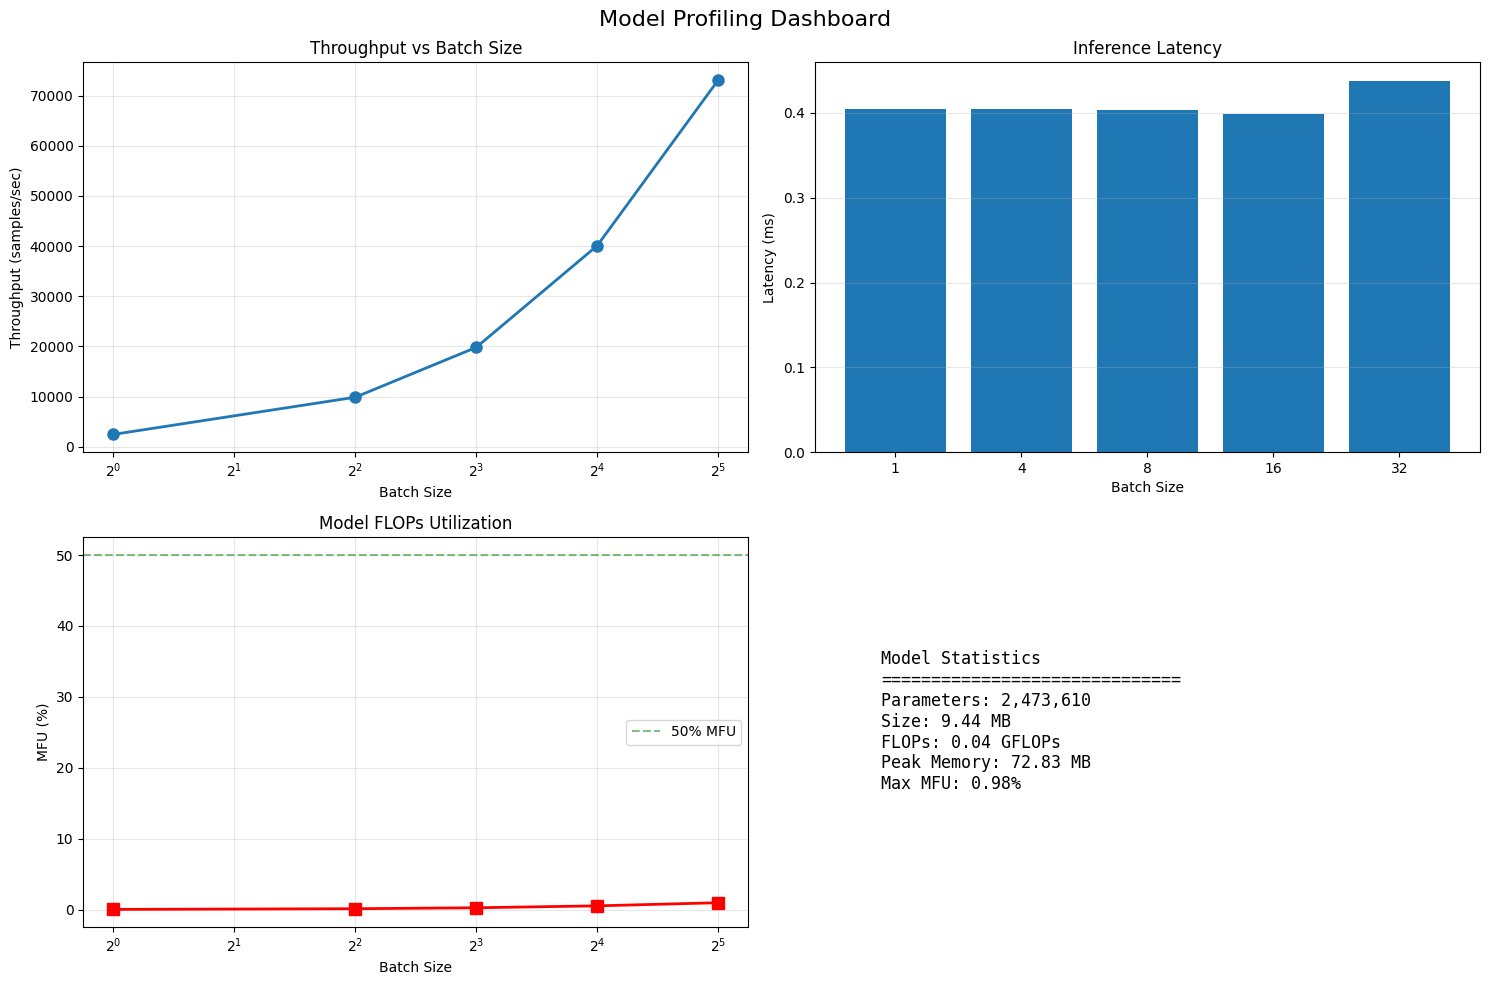

In [23]:
import matplotlib.pyplot as plt
import numpy as np

def create_profiling_dashboard(profiler_results):
    """프로파일링 결과 시각화 대시보드"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Profiling Dashboard', fontsize=16)

    # 1. Throughput vs Batch Size
    if 'batch_performance' in profiler_results:
        ax = axes[0, 0]
        batch_sizes = []
        throughputs = []

        for perf in profiler_results['batch_performance']:
            if 'throughput' in perf:
                batch_sizes.append(perf['batch_size'])
                throughputs.append(perf['throughput'])

        ax.plot(batch_sizes, throughputs, 'o-', linewidth=2, markersize=8)
        ax.set_xlabel('Batch Size')
        ax.set_ylabel('Throughput (samples/sec)')
        ax.set_title('Throughput vs Batch Size')
        ax.grid(True, alpha=0.3)
        ax.set_xscale('log', base=2)

    # 2. Latency vs Batch Size
    if 'batch_performance' in profiler_results:
        ax = axes[0, 1]
        batch_sizes = []
        latencies = []

        for perf in profiler_results['batch_performance']:
            if 'latency_ms' in perf:
                batch_sizes.append(perf['batch_size'])
                latencies.append(perf['latency_ms'])

        ax.bar(range(len(batch_sizes)), latencies, tick_label=batch_sizes)
        ax.set_xlabel('Batch Size')
        ax.set_ylabel('Latency (ms)')
        ax.set_title('Inference Latency')
        ax.grid(True, alpha=0.3, axis='y')

    # 3. MFU vs Batch Size
    if 'mfu' in profiler_results:
        ax = axes[1, 0]
        batch_sizes = []
        mfu_values = []

        for mfu_data in profiler_results['mfu']['measurements']:
            batch_sizes.append(mfu_data['batch_size'])
            mfu_values.append(mfu_data['mfu_percentage'])

        ax.plot(batch_sizes, mfu_values, 's-', linewidth=2, markersize=8, color='red')
        ax.set_xlabel('Batch Size')
        ax.set_ylabel('MFU (%)')
        ax.set_title('Model FLOPs Utilization')
        ax.grid(True, alpha=0.3)
        ax.set_xscale('log', base=2)
        ax.axhline(y=50, color='g', linestyle='--', alpha=0.5, label='50% MFU')
        ax.legend()

    # 4. Model Stats
    ax = axes[1, 1]
    ax.axis('off')

    stats_text = "Model Statistics\n" + "="*30 + "\n"

    if 'model_info' in profiler_results:
        info = profiler_results['model_info']
        stats_text += f"Parameters: {info['total_parameters']:,}\n"
        stats_text += f"Size: {info['model_size_mb']:.2f} MB\n"

    if 'flops' in profiler_results:
        stats_text += f"FLOPs: {profiler_results['flops']['gflops']:.2f} GFLOPs\n"

    if 'memory' in profiler_results:
        mem = profiler_results['memory']
        stats_text += f"Peak Memory: {mem['peak_memory_mb']:.2f} MB\n"

    if 'mfu' in profiler_results:
        max_mfu = max(m['mfu_percentage'] for m in profiler_results['mfu']['measurements'])
        stats_text += f"Max MFU: {max_mfu:.2f}%\n"

    ax.text(0.1, 0.5, stats_text, fontsize=12, family='monospace',
            verticalalignment='center')

    plt.tight_layout()
    plt.show()

# 대시보드 생성
create_profiling_dashboard(results)